In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm_notebook

import os
import itertools

import warnings
warnings.filterwarnings('ignore')

from pandas_profiling import ProfileReport

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import category_encoders

## Utils

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load data

In [4]:
data = pd.read_csv('data/bank-additional-full.csv.gz', engine='python', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## EDA

Let's check if there are missing values in target

In [5]:
data.y.isnull().sum()

0

Check classes balance. Classes are pretty imbalanced.

In [6]:
data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [7]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Ok, now we could explore data

<IPython.core.display.Javascript object>


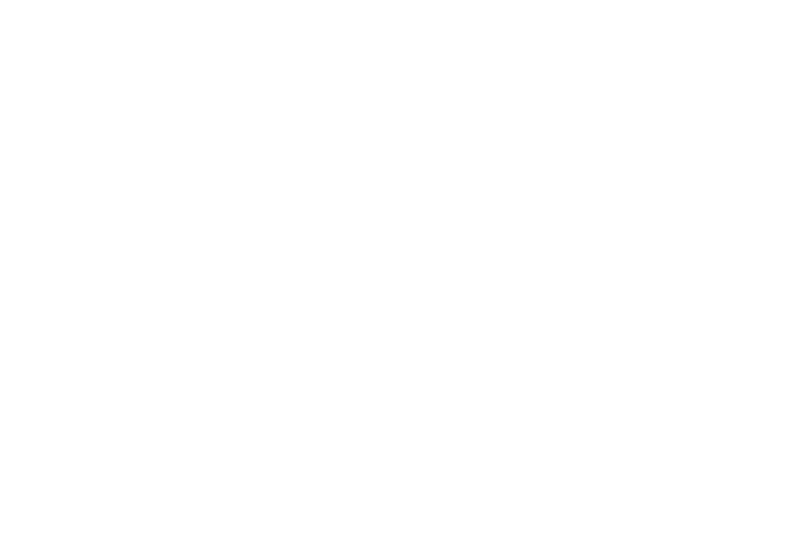

<IPython.core.display.Javascript object>


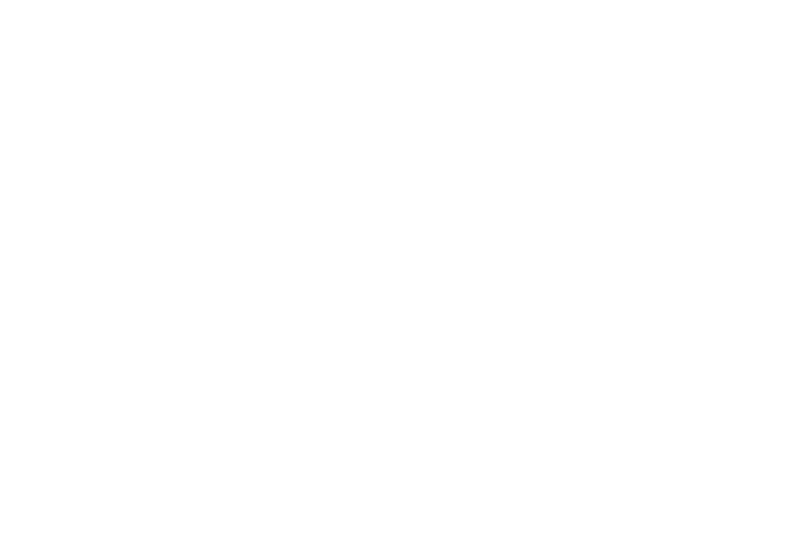

Number of variables,21
Number of observations,41188
Total Missing (%),0.0%
Total size in memory,6.6 MiB
Average record size in memory,168.0 B
Numeric,8
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


In [8]:
profile_report = ProfileReport(data)
profile_report

In [9]:
data.drop_duplicates(inplace=True)

In [10]:
continuous_features = profile_report.get_description()['variables'][profile_report.get_description()['variables'].type == 'NUM'].index.values.tolist()

In [11]:
continuous_features

['age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'duration',
 'emp.var.rate',
 'pdays',
 'previous']

<IPython.core.display.Javascript object>


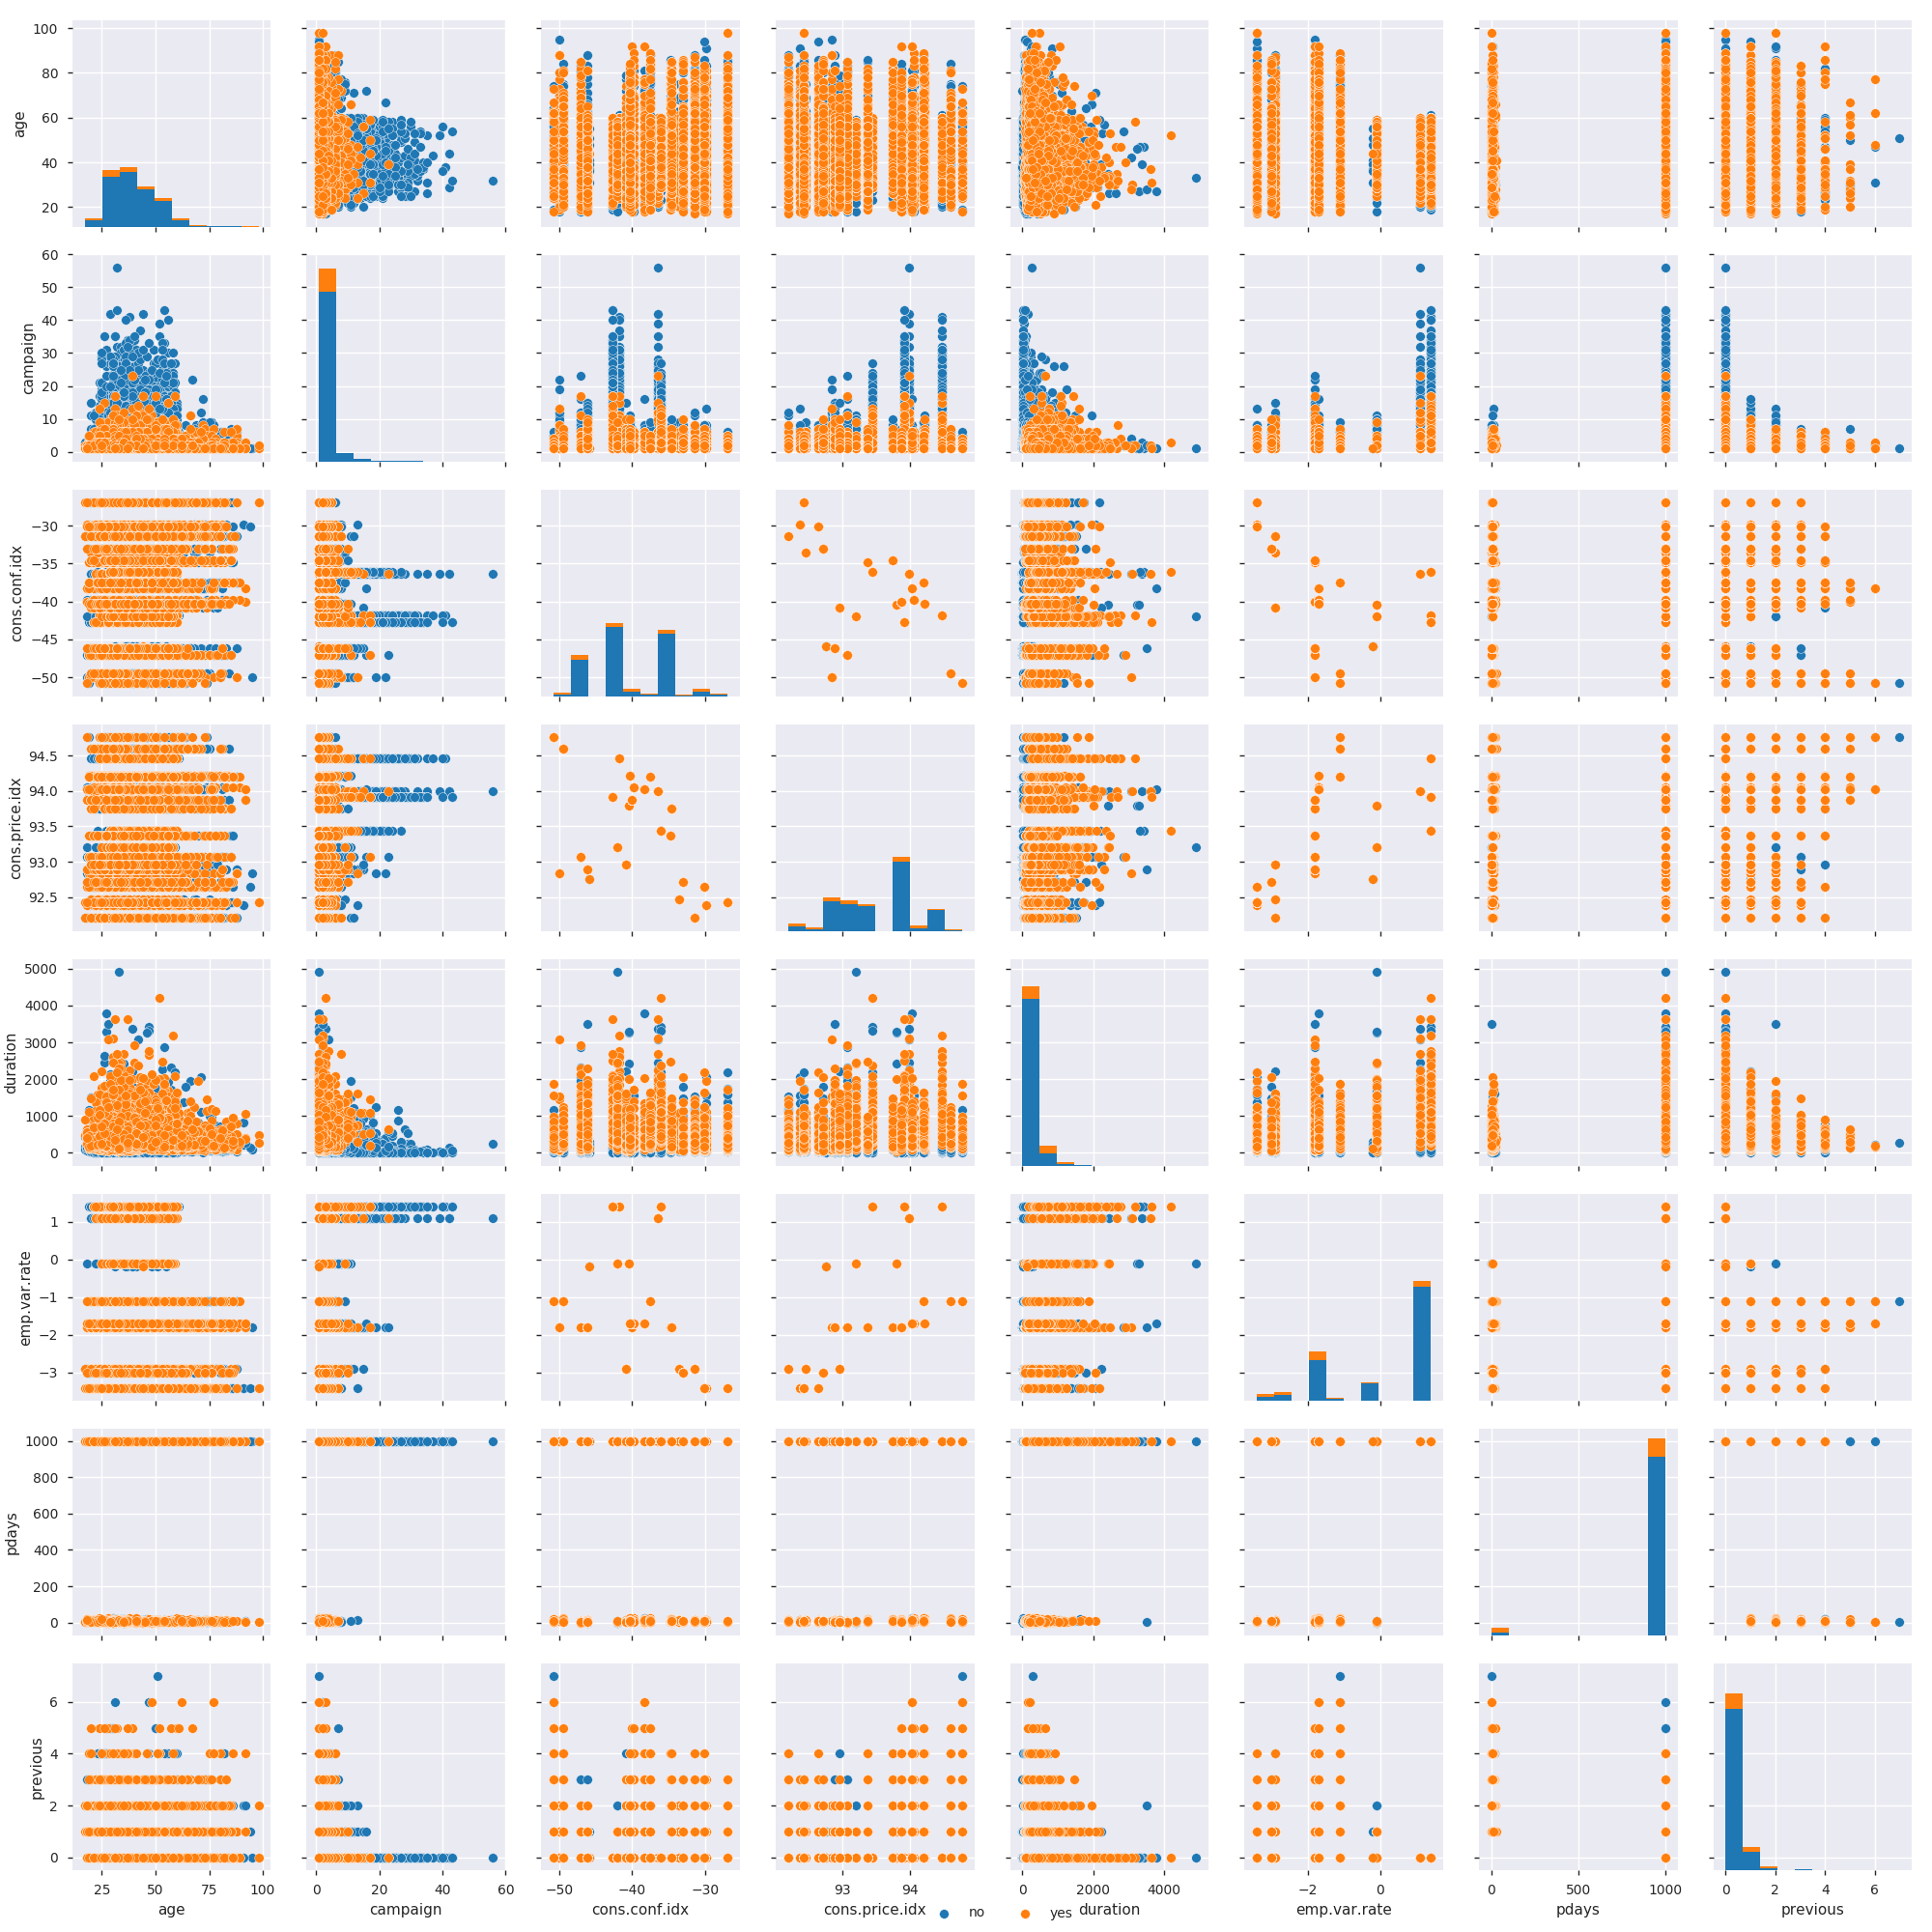

In [12]:
g = sns.pairplot(data[continuous_features + ['y']], hue='y')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=2)
g

<IPython.core.display.Javascript object>


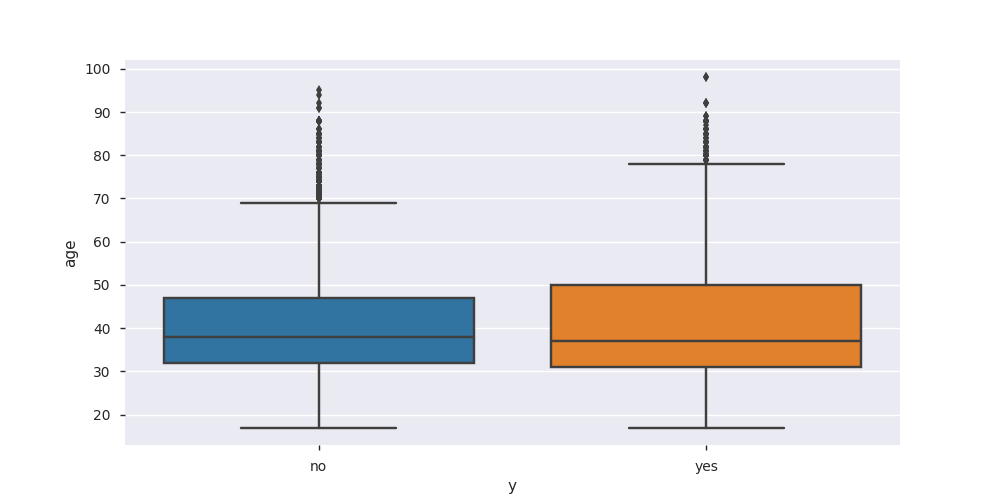

<IPython.core.display.Javascript object>


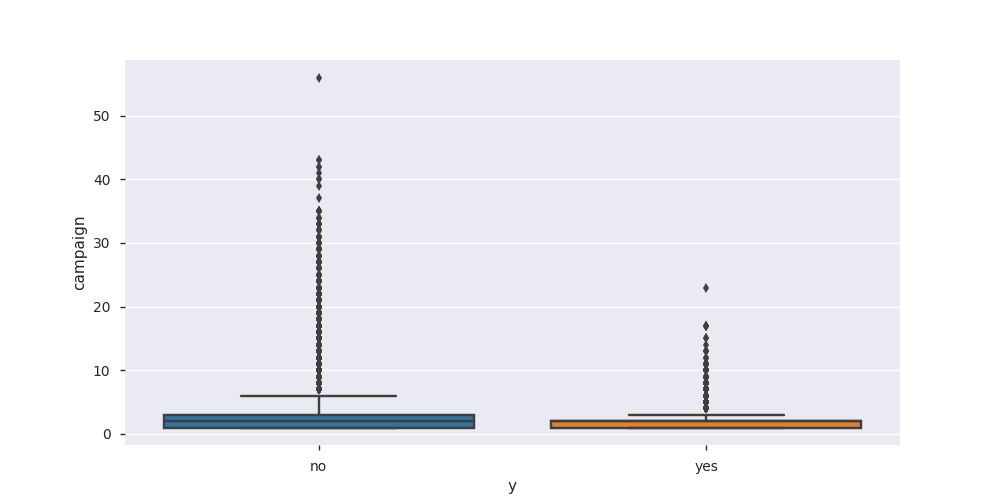

<IPython.core.display.Javascript object>


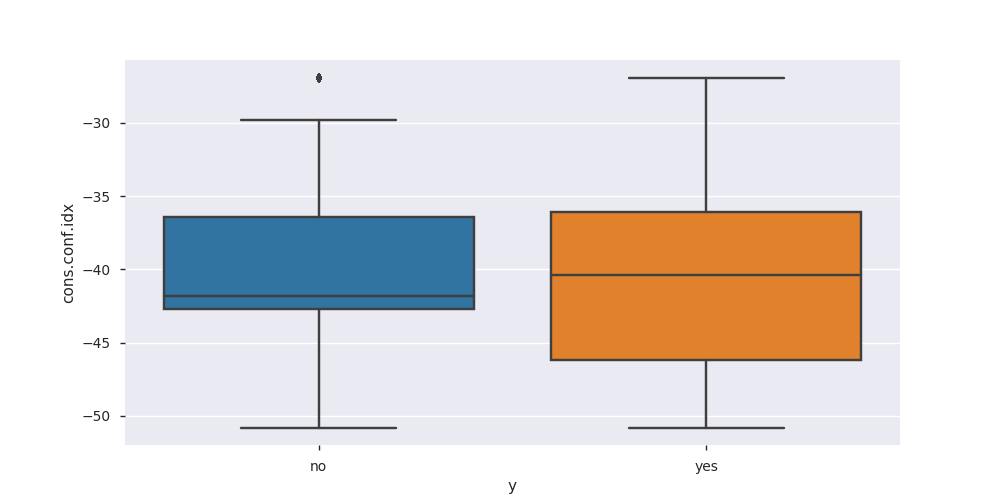

<IPython.core.display.Javascript object>


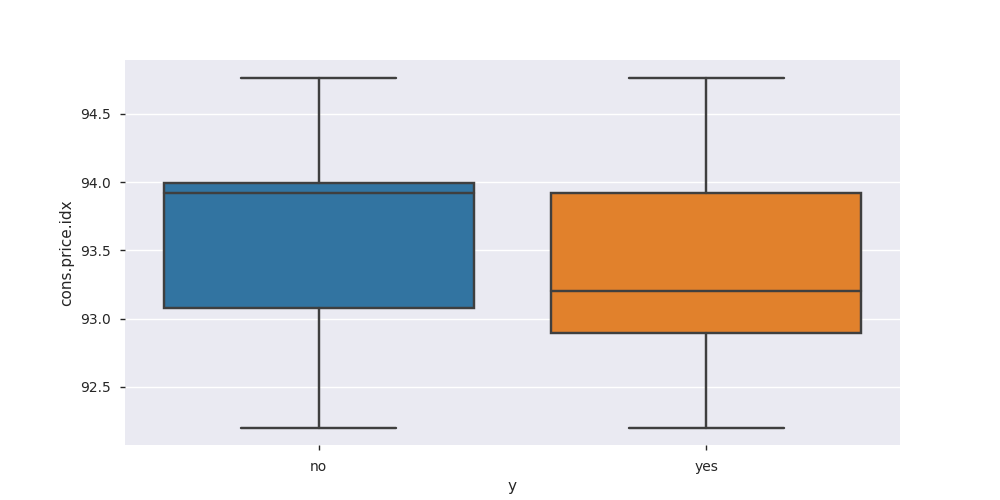

<IPython.core.display.Javascript object>


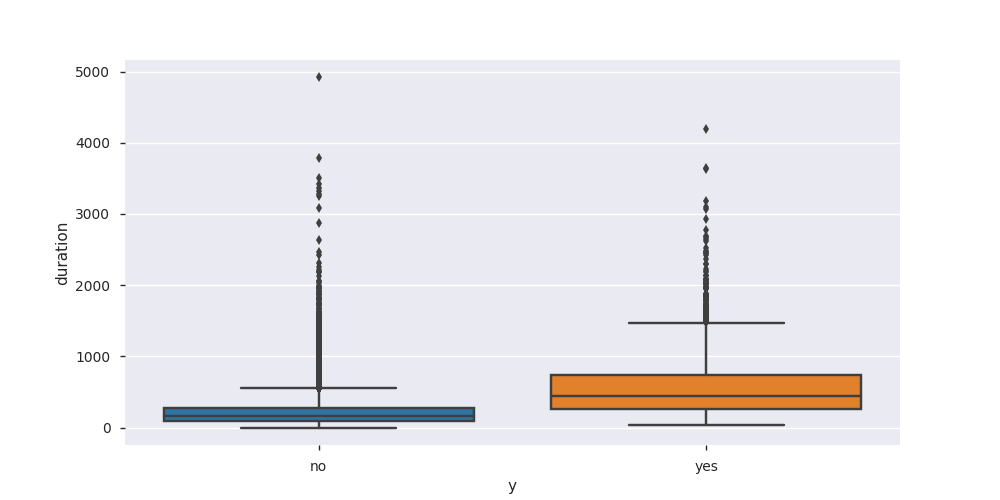

<IPython.core.display.Javascript object>


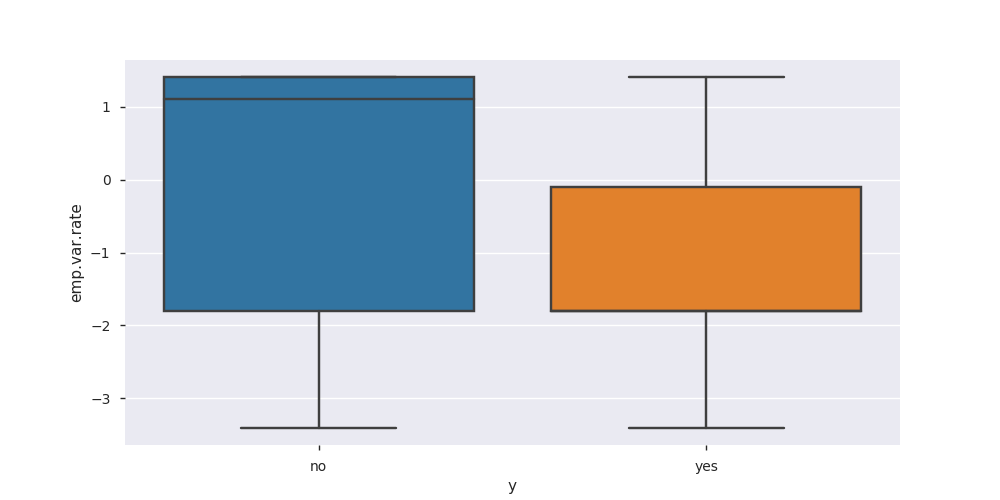

<IPython.core.display.Javascript object>


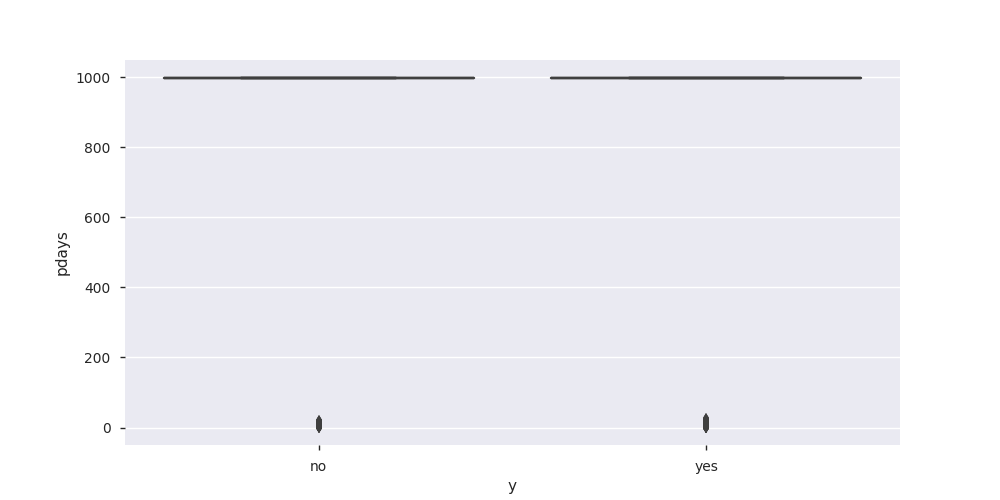

<IPython.core.display.Javascript object>


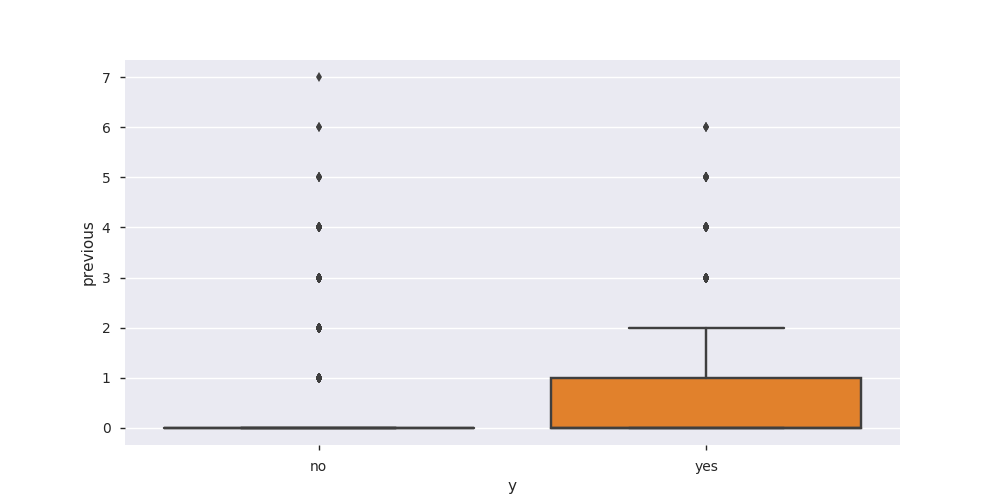

In [13]:
for column in continuous_features:
    plt.figure(figsize=(10,5))
    sns.boxplot(x = "y", y = column, data = data)

In [14]:
discrete_features = list(set(profile_report.get_description()['variables'][profile_report.get_description()['variables'].type == 'CAT'].index.values) - {'y'})
discrete_features

['marital',
 'poutcome',
 'housing',
 'education',
 'month',
 'loan',
 'default',
 'day_of_week',
 'contact',
 'job']

<IPython.core.display.Javascript object>


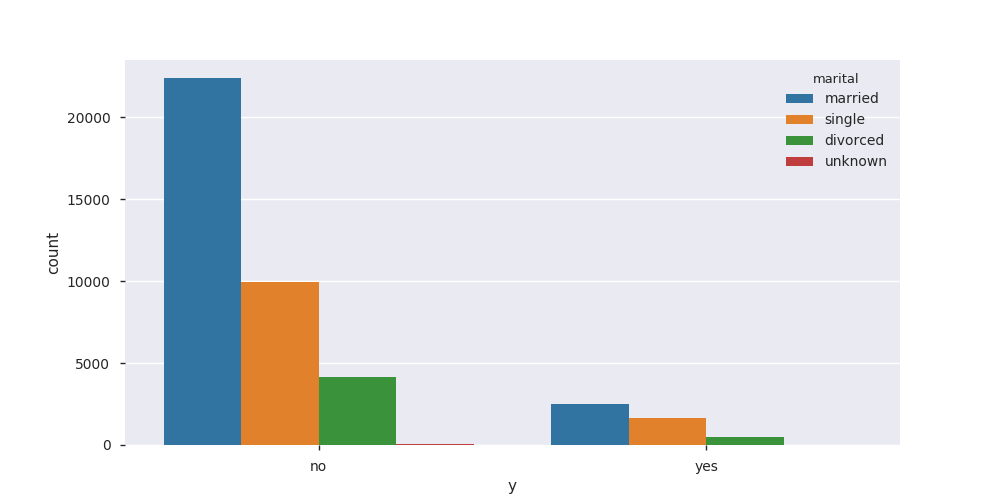

<IPython.core.display.Javascript object>


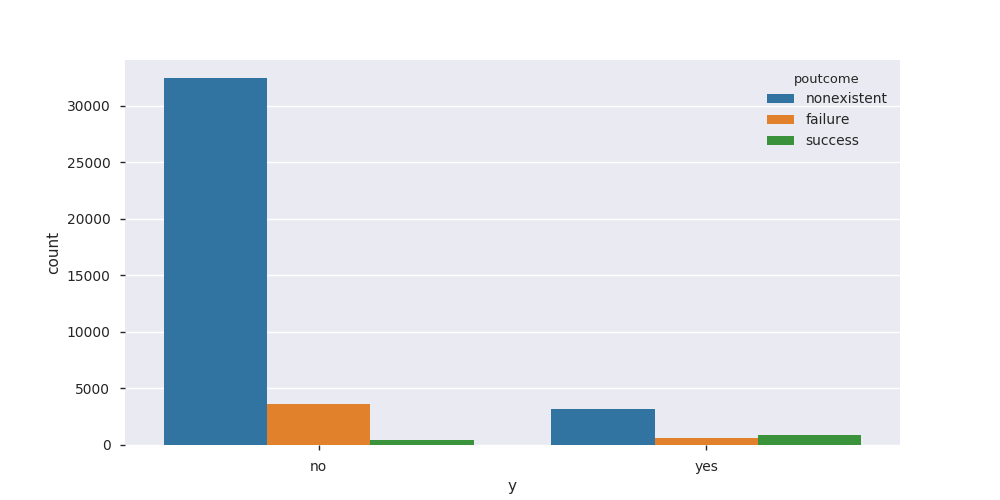

<IPython.core.display.Javascript object>


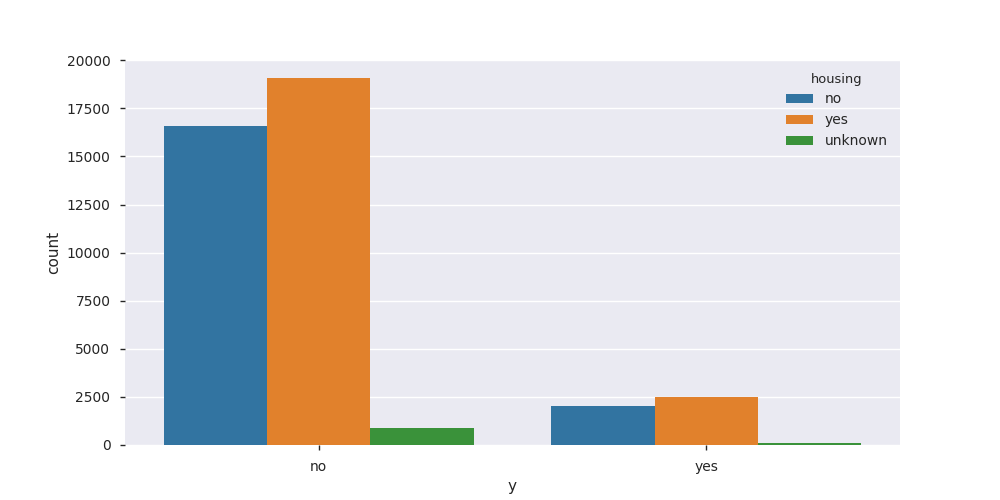

<IPython.core.display.Javascript object>


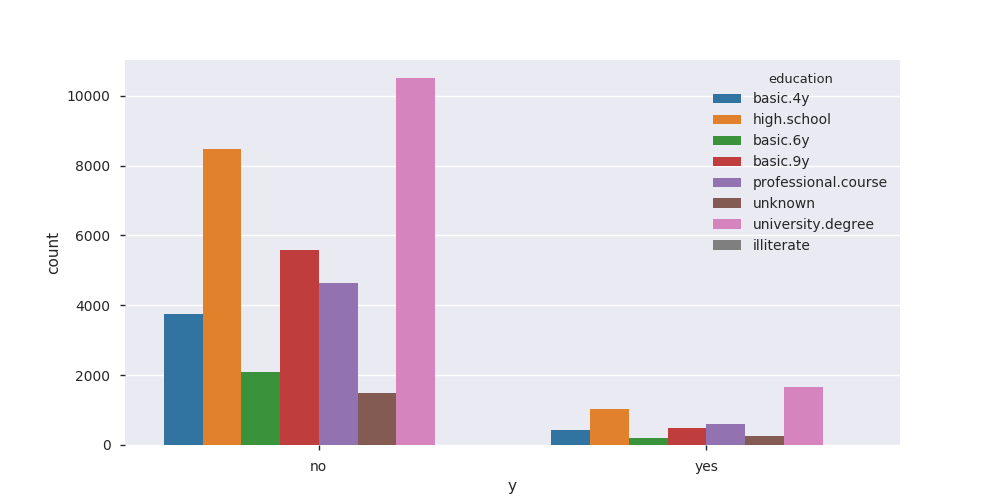

<IPython.core.display.Javascript object>


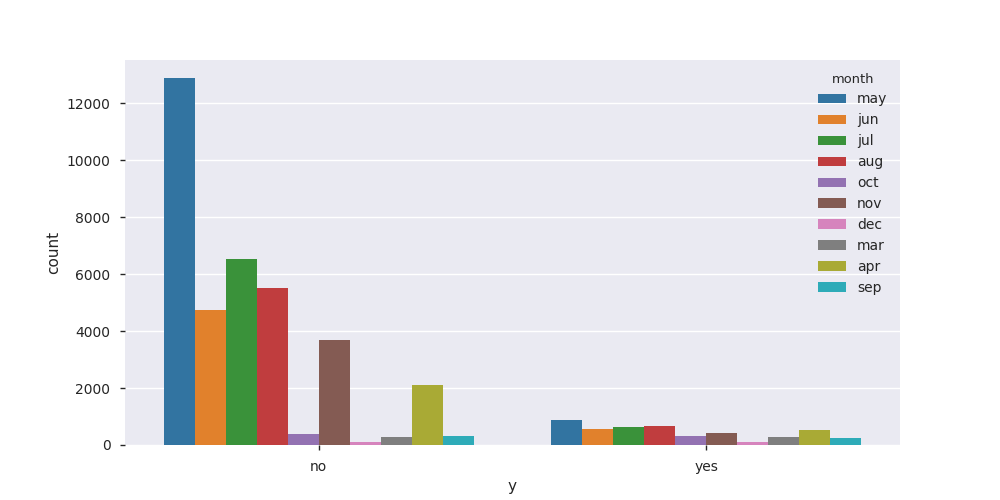

<IPython.core.display.Javascript object>


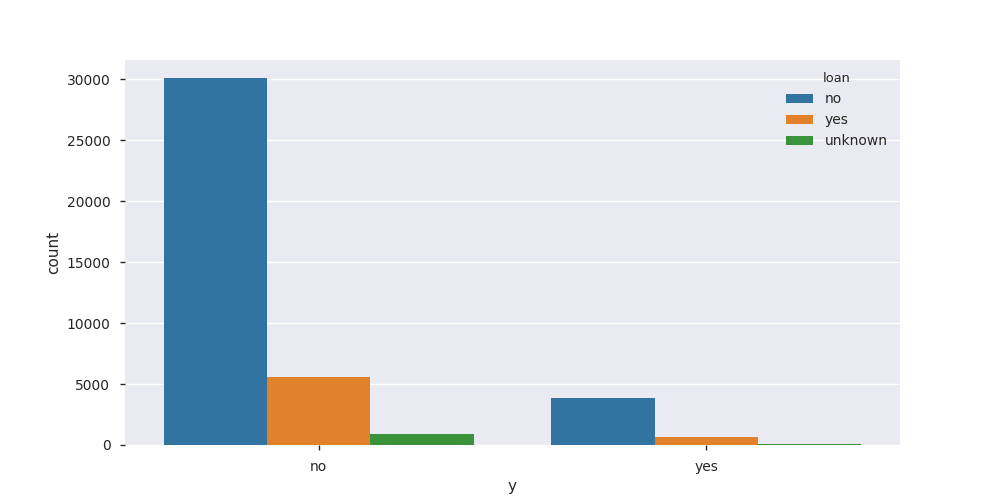

<IPython.core.display.Javascript object>


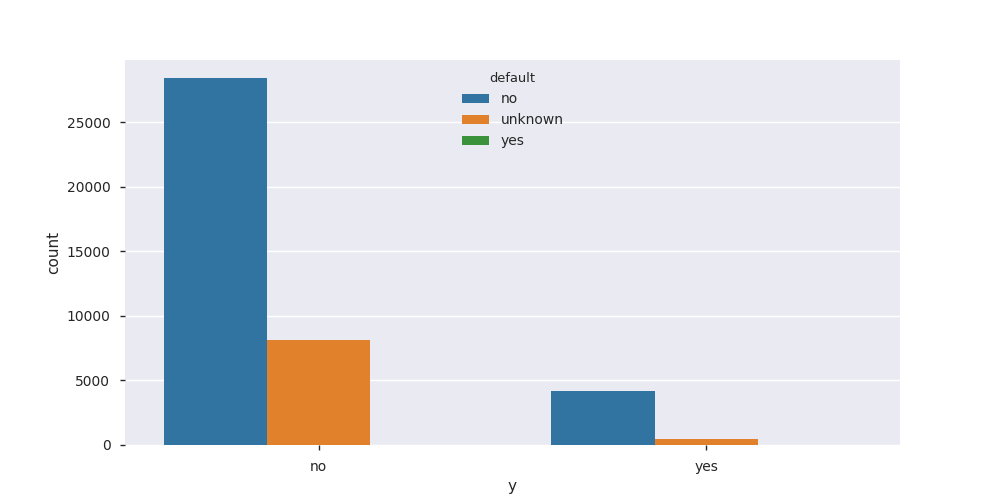

<IPython.core.display.Javascript object>


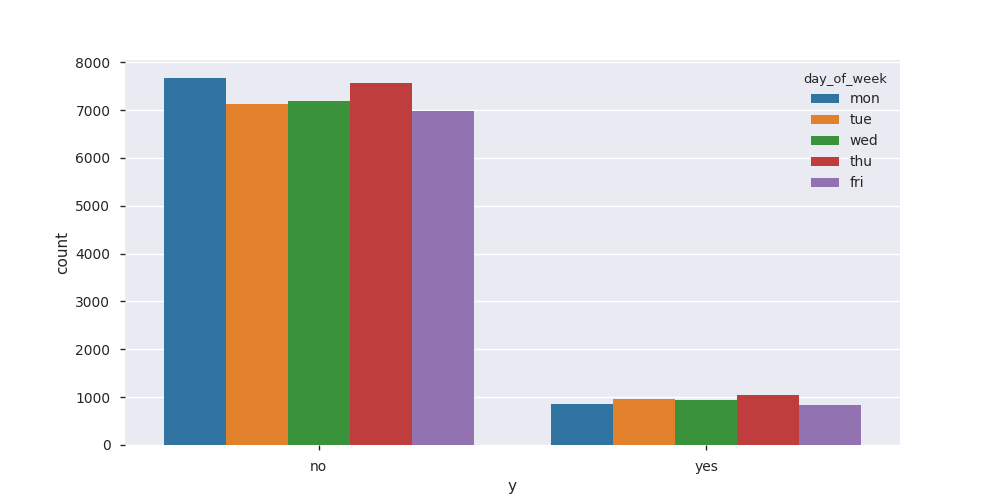

<IPython.core.display.Javascript object>


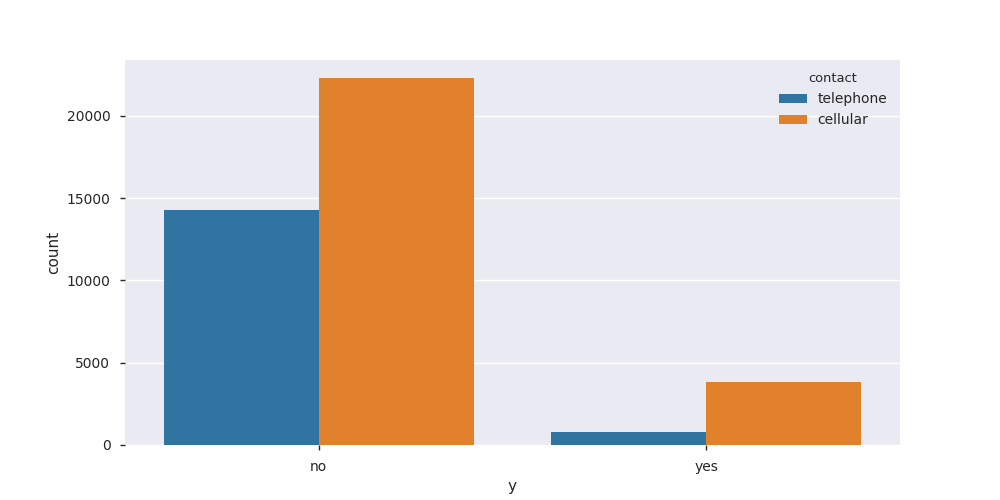

<IPython.core.display.Javascript object>


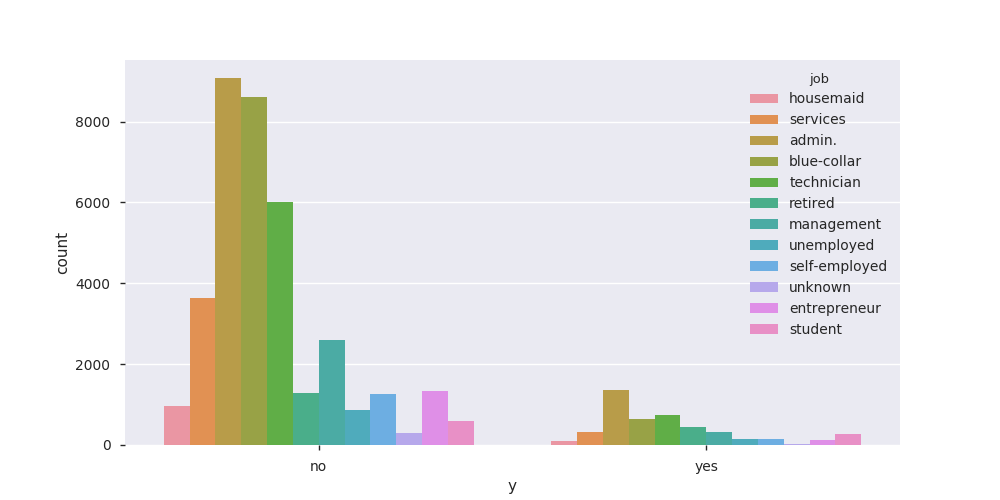

In [15]:
for column in discrete_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='y', hue=column, data=data)

Great, brief data exploration has been done. let's drop duration feature as it leak from future according to data description https://archive.ics.uci.edu/ml/datasets/Bank+Marketing and go to data processing

In [16]:
data.drop('duration', axis=1, inplace=True)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [17]:
continuous_features = list(set(continuous_features) - {'duration'})

## Data processing

### Train-test creation

In [18]:
X = data.drop('y', axis=1)
X.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [19]:
y = data['y']
y.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [20]:
X.shape, y.shape

((41176, 19), (41176,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)
X_train.shape

(28823, 19)

In [22]:
y_train.shape

(28823,)

### Features preprocessing

Features categorisation

In [23]:
class Quantizer():
    
    def __init__(self, quantiles_num):
        self.quantiles_num = quantiles_num
        
    def fit(self, feature_df):
        self.boundaries = pd.qcut(feature_df.drop_duplicates(), q=self.quantiles_num)
        
    def transform(self, feature_df):
        q_df = pd.cut(feature_df, self.boundaries.cat.categories)
        q_df = q_df.cat.rename_categories(list(range(0, self.quantiles_num)))
        return q_df.astype(str)
    
    def fit_transform(self, feature_df):
        self.fit(feature_df)
        q_df = self.transform(feature_df)
        return q_df

In [24]:
quantizer = Quantizer(5)

In [25]:
q_pdays_train = quantizer.fit_transform(X_train['pdays'])
q_pdays_train.head()

23917    4
5604     4
30721    4
13336    4
30805    4
Name: pdays, dtype: object

In [26]:
q_pdays_test = quantizer.transform(X_test['pdays'])
q_pdays_test.head()

13107    4
25072    4
21982    4
25292    4
27761    4
Name: pdays, dtype: object

One-Hot-encoding of categorical features

In [27]:
pipeline = make_pipeline(category_encoders.OneHotEncoder(handle_unknown="ignore"))

X_train_1_1 = pipeline.fit_transform(pd.concat([X_train[discrete_features], q_pdays_train], axis=1))
X_test_1_1 = pipeline.transform(pd.concat([X_test[discrete_features], q_pdays_test], axis=1))

print( X_train_1_1.shape, X_test_1_1.shape)

(28823, 58) (12353, 58)


In [28]:
X_train_1_1.head()

,marital_1,marital_2,marital_3,marital_4,poutcome_1,poutcome_2,poutcome_3,housing_1,housing_2,housing_3,...,job_8,job_9,job_10,job_11,job_12,pdays_1,pdays_2,pdays_3,pdays_4,pdays_5
23917,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5604,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
30721,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
13336,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
30805,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
X_train_1_1.index = list(range(X_train_1_1.shape[0]))
X_test_1_1.index = list(range(X_test_1_1.shape[0]))

Scaling

In [30]:
sc = StandardScaler()
X_train_1_2 = pd.DataFrame(sc.fit_transform(X_train[list(set(continuous_features) - {'pdays'})]), columns=list(set(continuous_features) - {'pdays'}))
X_test_1_2 = pd.DataFrame(sc.transform(X_test[list(set(continuous_features) - {'pdays'})]), columns=list(set(continuous_features) - {'pdays'}))
X_train_1_2.head()

,cons.price.idx,age,previous,campaign,cons.conf.idx,emp.var.rate
0,-0.224528,0.091889,-0.350333,1.597641,0.954882,0.842920
1,0.725049,-1.539210,-0.350333,-0.565104,0.890065,0.651906
2,-1.175830,0.859465,1.645249,-0.565104,-1.227291,-1.194565
3,0.593834,-1.251369,-0.350333,1.237184,-0.471092,0.842920
4,-1.175830,0.763518,-0.350333,-0.565104,-1.227291,-1.194565


In [31]:
X_train_1_2.shape

(28823, 6)

In [61]:
X_train_1 = pd.concat([X_train_1_1, X_train_1_2], axis=1)
X_train_1.shape

(28823, 64)

In [62]:
X_test_1 = pd.concat([X_test_1_1, X_test_1_2], axis=1)
X_test_1.shape

(12353, 64)

In [34]:
y_train = y_train.replace({'yes': 1, 'no': 0})
y_test = y_test.replace({'yes': 1, 'no': 0})
y_train.head()

23917    0
5604     0
30721    1
13336    0
30805    0
Name: y, dtype: int64

## Logistic regression

In [35]:
my_scorer = make_scorer(f1_score, average='macro')
skv = StratifiedKFold(5)

In [36]:
%%time

tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)

clf.fit(X_train_1.values, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   0.3s
[CV] C=0.05 .....

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


[CV] ............................................. C=50, total=   0.4s
[CV] ............................................. C=10, total=   0.7s
[CV] C=50 ............................................................
[CV] C=50 ............................................................
[CV] ............................................. C=50, total=   0.8s
[CV] ............................................. C=50, total=   0.8s
[CV] ............................................. C=50, total=   0.7s
[CV] ............................................. C=50, total=   0.6s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.1s finished


CPU times: user 1.91 s, sys: 70.2 ms, total: 1.98 s
Wall time: 6.8 s


In [37]:
clf.best_estimator_

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
y_true, y_pred = y_test, clf.predict(X_test_1.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.85      0.90     10961
          1       0.35      0.62      0.45      1392

avg / total       0.88      0.83      0.85     12353



In [39]:
class_names = [0, 1]

<IPython.core.display.Javascript object>


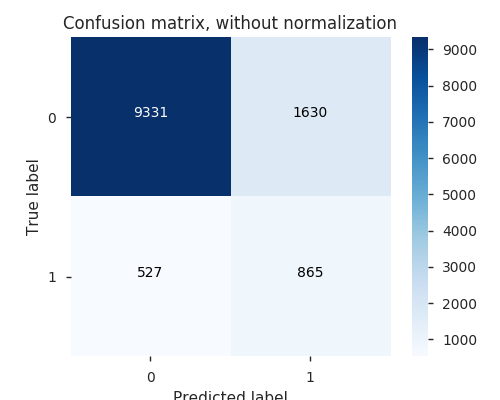

<IPython.core.display.Javascript object>


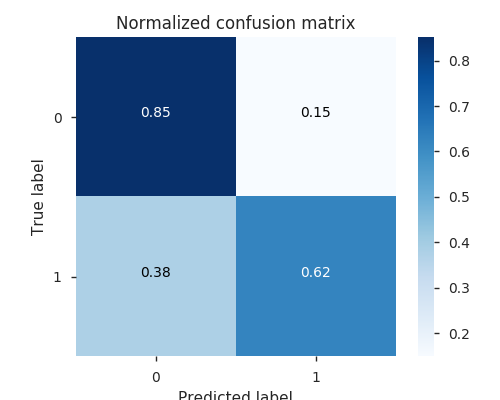

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## KNN Classifier

In [41]:
%%time

tuned_parameters = [{'n_neighbors': [ 3, 5, 7], 
                     'weights': ['uniform', 'distance']}]

clf = GridSearchCV( KNeighborsClassifier(), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)
clf.fit( X_train_1, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] ................... weights=uniform, n_neighbors=3, total=   8.8s
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] ................... weights=uniform, n_neighbors=3, total=   8.9s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   8.8s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   9.0s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   9.3s
[CV] ............

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.9min finished


CPU times: user 1.96 s, sys: 270 ms, total: 2.23 s
Wall time: 5min 54s


In [43]:
%%time
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_1)
print(classification_report(y_true, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     10961
          1       0.52      0.28      0.36      1392

avg / total       0.87      0.89      0.87     12353

CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


<IPython.core.display.Javascript object>


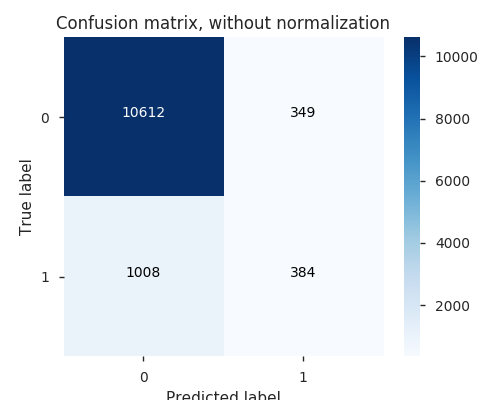

<IPython.core.display.Javascript object>


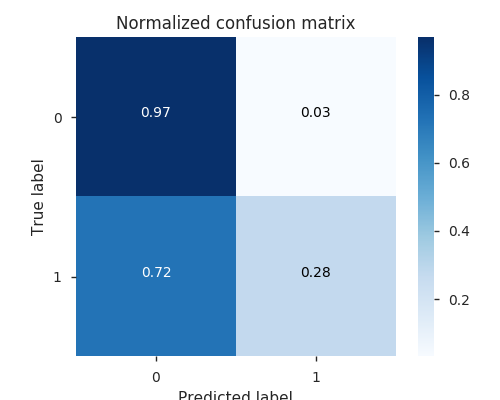

In [44]:
class_names = [0, 1]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## KNN with reduced feature space

<IPython.core.display.Javascript object>


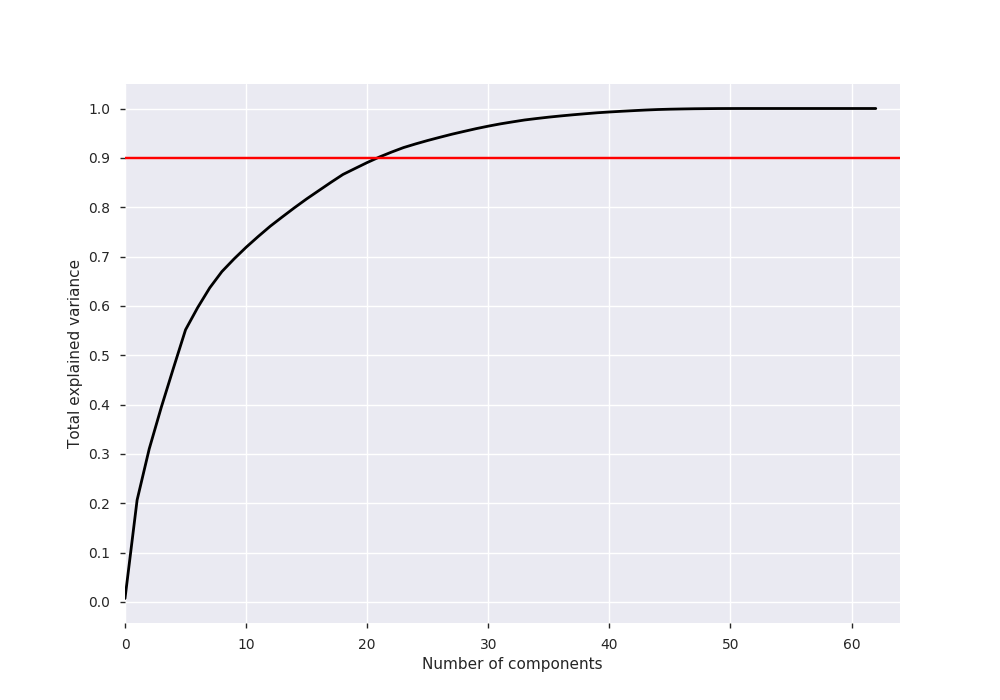

In [48]:
tSVD = TruncatedSVD( n_components=X_train_1.shape[1] - 1,  random_state=17).fit(X_train_1.values)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(tSVD.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, X_train_1.shape[1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show()

In [49]:
tSVD = TruncatedSVD(n_components=21, random_state=17)
X_train_2 = tSVD.fit_transform(X_train_1.values)
X_test_2 = tSVD.transform(X_test_1.values)

In [50]:
%%time

tuned_parameters = [{'n_neighbors': [ 3, 5, 7], 
                     'weights': ['uniform', 'distance']}]

clf = GridSearchCV( KNeighborsClassifier(), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)
clf.fit( X_train_2, y_train)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:32815)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/py4j-0.10.6-py3.5.egg/py4j/java_gateway.py", line 852, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/py4j-0.10.6-py3.5.egg/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] ................... weights=uniform, n_neighbors=3, total=   1.7s
[CV] weights=uniform, n_neighbors=3 ..................................
[CV] ................... weights=uniform, n_neighbors=3, total=   1.7s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   1.7s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   1.7s
[CV] weights=distance, n_neighbors=3 .................................
[CV] ................... weights=uniform, n_neighbors=3, total=   1.7s
[CV] weights=dist

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [52]:
%%time
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_2)
print(classification_report(y_true, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          0       0.91      0.96      0.93     10961
          1       0.43      0.26      0.33      1392

avg / total       0.86      0.88      0.86     12353

CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.34 s


<IPython.core.display.Javascript object>


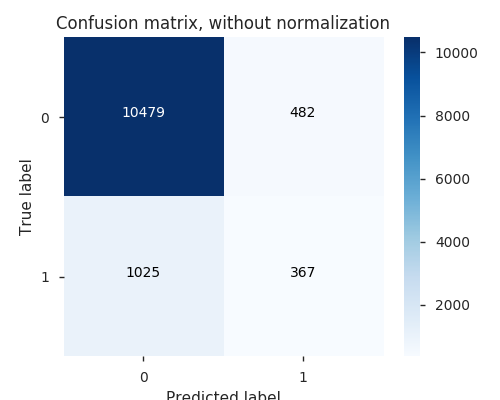

<IPython.core.display.Javascript object>


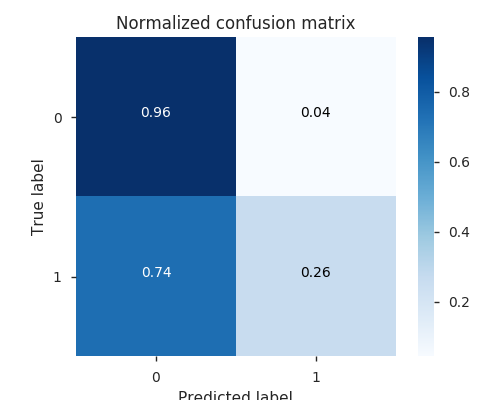

In [53]:
class_names = [0, 1]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Feature engineering

In [77]:
X_train_3 = X_train_1.copy()
X_test_3 = X_test_1.copy()
print(X_train_3.shape, X_test_3.shape)

(28823, 64) (12353, 64)


In [78]:
numeric_cols = list(X_train_3.select_dtypes(include=['float64']))
numeric_cols

['cons.price.idx',
 'age',
 'previous',
 'campaign',
 'cons.conf.idx',
 'emp.var.rate']

In [79]:
def brute_feat_gen(df, num_col_names):
    for name1 in tqdm_notebook(num_col_names):
        for name2 in num_col_names:
            df[name1 + "_X_" + name2] =  df[name1] * df[name2]
            df[name1 + "_powers3" ] =  df[name1] * df[name1] * df[name1]
    print( df.shape)
    return df

In [80]:
X_train_3_fg = brute_feat_gen(X_train_3, numeric_cols)


(28823, 106)


In [81]:
X_test_3_fg = brute_feat_gen(X_test_3, numeric_cols)


(12353, 106)


In [83]:
%%time

tuned_parameters = [{'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

clf = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1)
clf.fit(X_train_3_fg.values, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   1.5s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   1.6s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   1.7s
[CV] C=0.05 ..........................................................
[CV] ........................................... C=0.01, total=   1.6s
[CV] C=0.05 .....

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.8s


[CV] ............................................. C=10, total=   7.6s
[CV] C=50 ............................................................
[CV] ............................................. C=10, total=   7.9s
[CV] C=50 ............................................................
[CV] ............................................. C=50, total=   5.4s
[CV] C=50 ............................................................
[CV] ............................................. C=50, total=   8.5s
[CV] ............................................. C=50, total=   4.8s
[CV] ............................................. C=50, total=   6.2s
[CV] ............................................. C=50, total=   8.0s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.2s finished


CPU times: user 3.74 s, sys: 175 ms, total: 3.92 s
Wall time: 49.9 s


In [84]:
print(clf.best_estimator_)

y_true, y_pred = y_test, clf.predict(X_test_3_fg.values)
print(classification_report(y_true, y_pred))

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.95      0.85      0.90     10961
          1       0.35      0.63      0.45      1392

avg / total       0.88      0.83      0.85     12353



Previous run of logistic regression

precision    recall  f1-score   support

          0       0.95      0.85      0.90     10961
          1       0.35      0.62      0.45      1392
          /       0.88      0.83      0.85     12353

<IPython.core.display.Javascript object>


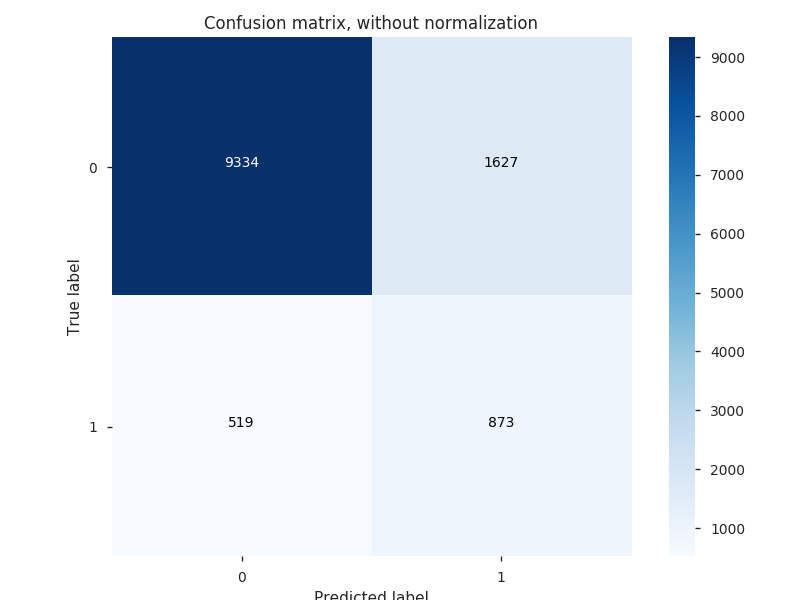

<IPython.core.display.Javascript object>


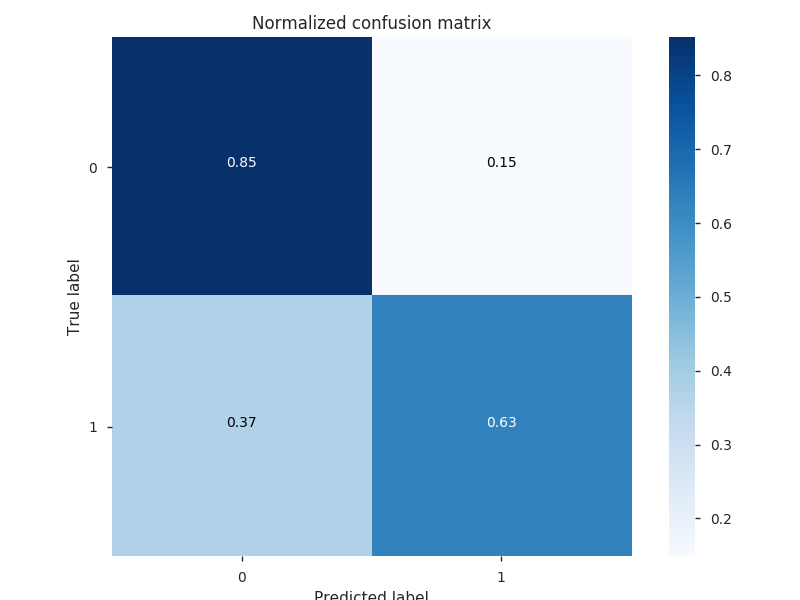

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Try to create your own features